In [ ]:
!pip install gym[all]
!pip install -U gym[atari,accept-rom-license]
!AutoROM --accept-license

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def save_weights_to_drive(model,DRIVE_PATH):
  %cp  $model $DRIVE_PATH
  
# save_weights_to_drive("/content/t.txt", DRIVE_PATH)

In [ ]:
import gym
import cv2

import time
import json
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

##hyper parameters

In [ ]:
ENVIRONMENT = "PongDeterministic-v4"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SAVE_MODELS = True  # Save models to file so you can test later
MODEL_PATH = "/content/pong-cnn-"  # Models path for saving or loading
DRIVE_PATH= "/content/gdrive/MyDrive/Pong/"
SAVE_MODEL_INTERVAL = 10  # Save models at every X epoch
TRAIN_MODEL = True  # Train model while playing (Make it False when testing a model)
#/content/pong-cnn-580.pkl
LOAD_MODEL_FROM_FILE = True  # Load model from file
LOAD_FILE_EPISODE = 740  # Load Xth episode from file

BATCH_SIZE = 64  # Minibatch size that select randomly from mem for train nets
MAX_EPISODE = 100000  # Max episode
MAX_STEP = 100000  # Max step size for one episode

MAX_MEMORY_LEN = 50000  # Max memory len
MIN_MEMORY_LEN = 40000  # Min memory len before start train

GAMMA = 0.97  # Discount rate
ALPHA = 0.00025  # Learning rate
EPSILON_DECAY = 0.99  # Epsilon decay rate by step

RENDER_GAME_WINDOW = False  # Opens a new window to render the game (Won't work on colab default)

the Double DQN algritm that we are implementing 
https://arxiv.org/abs/1511.06581

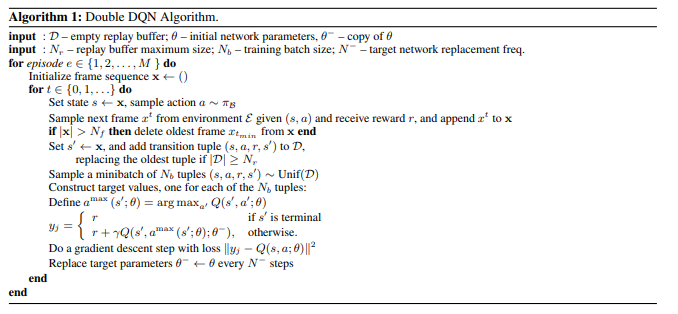

##CNN architecture 

In [ ]:
#CNN this will be the structure for both the online and target model.
class DuelCNN(nn.Module):
    def __init__(self, h, w, output_size):
        super(DuelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4,  out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        convw, convh = self.conv2d_size_calc(w, h, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        convw, convh = self.conv2d_size_calc(convw, convh, kernel_size=3, stride=1)

        linear_input_size = convw * convh * 64  # Last conv layer's out sizes

        # Action layer
        self.Alinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Alrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Alinear2 = nn.Linear(in_features=128, out_features=output_size)

        # State Value layer
        self.Vlinear1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.Vlrelu = nn.LeakyReLU()  # Linear 1 activation funct
        self.Vlinear2 = nn.Linear(in_features=128, out_features=1)  # Only 1 node
        
    #calculate the Convelotional layers output size
    def conv2d_size_calc(self, w, h, kernel_size=5, stride=2):
        next_w = (w - (kernel_size - 1) - 1) // stride + 1
        next_h = (h - (kernel_size - 1) - 1) // stride + 1
        return next_w, next_h

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten every batch

        Ax = self.Alrelu(self.Alinear1(x))
        Ax = self.Alinear2(Ax)  # No activation on last layer

        Vx = self.Vlrelu(self.Vlinear1(x))
        Vx = self.Vlinear2(Vx)  # No activation on last layer

        q = Vx + (Ax - Ax.mean())

        return q

##The agent class

In [ ]:
class Agent:
    def __init__(self, environment):
        """
        Hyperparameters definition for Agent
        """
        # State size for Pong environment is (210, 160, 3). 
        self.state_size_h = environment.observation_space.shape[0]
        self.state_size_w = environment.observation_space.shape[1]
        self.state_size_c = environment.observation_space.shape[2]

        # actions size for Pong environment is 6
        self.action_size = environment.action_space.n

        # Image pre process params
        self.target_h = 80  # Height after process
        self.target_w = 64  # Widht after process

        self.crop_dim = [20, self.state_size_h, 0, self.state_size_w]  # Cut 20 px from top to get rid of the score table

        # Trust rate to our experiences
        self.gamma = GAMMA  # Discount factor for future predictions
        self.alpha = ALPHA  # Learning Rate

        # After many experinces epsilon will be 0.05
        # So we will do less Explore more Exploit
        self.epsilon = 1  # Explore or Exploit
        self.epsilon_decay = EPSILON_DECAY  # Adaptive Epsilon Decay Rate
        self.epsilon_minimum = 0.05  # Minimum for Explore

        # Deque to stor experience replay .
        self.memory = deque(maxlen=MAX_MEMORY_LEN)

        # initialize the two model for DDQN algorithm online model, target model
        self.online_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model = DuelCNN(h=self.target_h, w=self.target_w, output_size=self.action_size).to(DEVICE)
        self.target_model.load_state_dict(self.online_model.state_dict())
        #we put target model in evaluation mode because we don't want it to train 
        self.target_model.eval()

        # Adam used as optimizer
        self.optimizer = optim.Adam(self.online_model.parameters(), lr=self.alpha)
    
    #Process image crop resize, grayscale and normalize the images
    def preProcess(self, image):
        frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # To grayscale
        frame = frame[self.crop_dim[0]:self.crop_dim[1], self.crop_dim[2]:self.crop_dim[3]]  # Cut 20 px from top
        frame = cv2.resize(frame, (self.target_w, self.target_h))  # Resize
        frame = frame.reshape(self.target_w, self.target_h) / 255  # Normalize

        return frame

    #epsilon greedy algorithm to explor and exploit
    def act(self, state):
        act_protocol = 'Explore' if random.uniform(0, 1) <= self.epsilon else 'Exploit'

        if act_protocol == 'Explore':
            action = random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float, device=DEVICE).unsqueeze(0)
                q_values = self.online_model.forward(state)  # (1, action_size)
                action = torch.argmax(q_values).item()  # Returns the indices of the maximum value of all elements

        return action
    #experience replay to train the model
    def train(self):
        if len(agent.memory) < MIN_MEMORY_LEN:
            loss, max_q = [0, 0]
            return loss, max_q
        # sample a minibatch from the memory
        state, action, reward, next_state, done = zip(*random.sample(self.memory, BATCH_SIZE))

        # Concat batches in one array
        # (np.arr, np.arr) ==> np.BIGarr
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)

        # Convert them to tensors
        state = torch.tensor(state, dtype=torch.float, device=DEVICE)
        next_state = torch.tensor(next_state, dtype=torch.float, device=DEVICE)
        action = torch.tensor(action, dtype=torch.long, device=DEVICE)
        reward = torch.tensor(reward, dtype=torch.float, device=DEVICE)
        done = torch.tensor(done, dtype=torch.float, device=DEVICE)

        # Make predictions
        state_q_values = self.online_model(state)
        next_states_q_values = self.online_model(next_state)
        next_states_target_q_values = self.target_model(next_state)

        # Find selected action's q_value
        selected_q_value = state_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        # Get indice of the max value of next_states_q_values
        # Use that indice to get a q_value from next_states_target_q_values
        # We use greedy for policy So it called off-policy
        next_states_target_q_value = next_states_target_q_values.gather(1, next_states_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
        # Use Bellman function to find expected q value
        expected_q_value = reward + self.gamma * next_states_target_q_value * (1 - done)

        # Calc loss with expected_q_value and q_value
        loss = (selected_q_value - expected_q_value.detach()).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, torch.max(state_q_values).item()

    #add new experince to the replay memory 
    def storeResults(self, state, action, reward, nextState, done):
        self.memory.append([state[None, :], action, reward, nextState[None, :], done])

    #decay epsilon at every step to allow our model to exploit more as it trains
    def adaptiveEpsilon(self):
        if self.epsilon > self.epsilon_minimum:
            self.epsilon *= self.epsilon_decay

In [ ]:
weightsPath = MODEL_PATH + str(LOAD_FILE_EPISODE) + '.pkl'
epsilonPath = MODEL_PATH + str(LOAD_FILE_EPISODE) + '.json'

In [ ]:
# create the environment 
environment = gym.make(ENVIRONMENT,  render_mode='rgb_array')  
#create an instance of agent class
agent = Agent(environment)  

#load pretrained weights if we already trined
if LOAD_MODEL_FROM_FILE:
    agent.online_model.load_state_dict(torch.load(MODEL_PATH+str(LOAD_FILE_EPISODE)+".pkl"))

    with open(MODEL_PATH+str(LOAD_FILE_EPISODE)+'.json') as outfile:
        param = json.load(outfile)
        agent.epsilon = param.get('epsilon')

    startEpisode = LOAD_FILE_EPISODE + 1
#start with eps=1 and random weights because we didn't train yet
else:
    startEpisode = 1

#data structure deque to store the last 100 episode rewards
last_100_ep_reward = deque(maxlen=100)  
total_step = 1  
for episode in range(startEpisode, MAX_EPISODE):

    startTime = time.time()  # store the time
    # Reset env at the beginning of each episode
    state = environment.reset()  
    #get the observations from the environment
    state= environment.render()

    #process the observations to get suitable images that can be fed to the CNNs
    state = agent.preProcess(state)  


    #stack observations to create the state "4 consecutive observations makes a state"
    state = np.stack((state, state, state, state))

    total_max_q_val = 0  # Total max q vals
    total_reward = 0  # Total reward for each episode
    total_loss = 0  # Total loss for each episode
    for step in range(MAX_STEP):

        #if we want to show how is the model playing we can render the opervations 
        #this doesn't work probably yet since we are working with colab and we dont have a monitor to show the observations
        if RENDER_GAME_WINDOW:
            environment.render()  

        # use epsilon greedy to select an action to be perforemed on the environemt
        action = agent.act(state)  
        #get the next observation, reward, and done to show of we reached a terminal state.
        next_state, reward, done,_,  info = environment.step(action) 

        #process the new observations to create the next state
        next_state = agent.preProcess(next_state)  

        #add the new observation to the already defined state to create the new state
        next_state = np.stack((next_state, state[0], state[1], state[2]))

        # Store the transition in memory
        agent.storeResults(state, action, reward, next_state, done)  # Store to mem

        # Update state 
        state = next_state  

        if TRAIN_MODEL:
            # Perform one step of the optimization (on the target network)
            #using the experience replay algorithm
            loss, max_q_val = agent.train()  
        else:
            loss, max_q_val = [0, 0]

        total_loss += loss
        total_max_q_val += max_q_val
        total_reward += reward
        total_step += 1
        if total_step % 1000 == 0:
            # decay epsilon each 1000 steps
            agent.adaptiveEpsilon()  

        # we compleated an episode 
        if done:  
            #store the finish time
            currentTime = time.time()  
            # get the episode duration
            time_passed = currentTime - startTime  
            # Get current dateTime as HH:MM:SS
            current_time_format = time.strftime("%H:%M:%S", time.gmtime())  
            # Create epsilon dict to save model as file
            epsilonDict = {'epsilon': agent.epsilon}  
            
            # Save model to the over come Ram craches 
            if SAVE_MODELS and episode % SAVE_MODEL_INTERVAL == 0:  
                weightsPath = MODEL_PATH + str(episode) + '.pkl'
                epsilonPath = MODEL_PATH + str(episode) + '.json'

                torch.save(agent.online_model.state_dict(), weightsPath)
                with open(epsilonPath, 'w') as outfile:
                    json.dump(epsilonDict, outfile)

            if TRAIN_MODEL:
                # Update target model at the end of the episode target_model = online_model
                agent.target_model.load_state_dict(agent.online_model.state_dict())  

            last_100_ep_reward.append(total_reward)
            avg_max_q_val = total_max_q_val / step

            #create output file to show the results later
            outStr = "Episode:{} Time:{} Reward:{:.2f} Loss:{:.2f} Last_100_Avg_Rew:{:.3f} Avg_Max_Q:{:.3f} Epsilon:{:.2f} Duration:{:.2f} Step:{} CStep:{}".format(
                episode, current_time_format, total_reward, total_loss, np.mean(last_100_ep_reward), avg_max_q_val, agent.epsilon, time_passed, step, total_step
            )

            print(outStr)

            #save the output file, model and epsilon value to the drive
            if SAVE_MODELS:
                outputPath = MODEL_PATH + "out" + '.txt'  # Save outStr to file
                with open(outputPath, 'a') as outfile:
                    outfile.write(outStr+"\n")
                save_weights_to_drive(weightsPath,DRIVE_PATH)
                save_weights_to_drive(epsilonPath,DRIVE_PATH)
                save_weights_to_drive(outputPath,DRIVE_PATH)


            break


In [ ]:
# after 3 hours alomest reashed the avwrage reward of 4.4
#after 346 epispdes the average reward is 10.86 and it took 3:30 h to train 
# after 5:46 trained 545 episodes and got reward of 14.26

##Results and processing output:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#process the output file and create dictionary info to store the importabt information
info={}
with open("/content/pong-cnn-out.txt", "r") as input_file:
  for line  in input_file:
    a,b,c,d,e,f,g,h,i,j=(item.strip() for item in line.split(' ',9))
    a,a_= a.split(":")
    c,c_= c.split(":")
    d,d_= d.split(":")
    e,e_= e.split(":")
    f,f_= f.split(":")
    g,g_= g.split(":")
    h,h_= h.split(":")
    i,i_= i.split(":")
    j,j_= j.split(":")
    tempdict= dict(zip((c,d,e,f,g,h,i,j),(c_,d_,e_,f_,g_,h_,i_,j_)))
    info[a_]= tempdict
    

In [ ]:
#show the stored info for each episode 
episode_='1'
info[episode_]

{'Reward': '-21.00',
 'Loss': '0.00',
 'Last_100_Avg_Rew': '-21.000',
 'Avg_Max_Q': '0.000',
 'Epsilon': '1.00',
 'Duration': '0.98',
 'Step': '883',
 'CStep': '885'}

In [ ]:
#some values got missed up because of mulipule RAM craches so solving this problem 
#stor the info into lists to plot them later and fix the problems
Reward=[]
Loss=[]
Last_100_Avg_Rew=[]
Avg_Max_Q=[]
Epsilon=[]
Duration=[]
Step=[]
for i in range(len(info)):
  Reward.append(float(info[str(i+1)]["Reward"]))
  Loss.append(float(info[str(i+1)]["Loss"]))
  Last_100_Avg_Rew.append(float(info[str(i+1)]["Last_100_Avg_Rew"]))
  Avg_Max_Q.append(float(info[str(i+1)]["Avg_Max_Q"]))
  Epsilon.append(float(info[str(i+1)]["Epsilon"]))
  Step.append(float(info[str(i+1)]["Step"]))
  Duration.append(float(info[str(i+1)]["Duration"]))


In [ ]:
#define window length to calculate moving/running average
N=100

In [ ]:
reward_moving_averages=[]
window_average=0
#after 500 the mean average 100 ep got missed up because of ram issues so we have to recalculate them
i=0
for i in range(500):
  reward_moving_averages.append(Last_100_Avg_Rew[i])


i=500
while i < len(Reward):
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = Reward[i-N : i ]
  
    # Calculate the average of current window
    window_average = round(sum(window) / N, 2)
      
    # Store the average of current
    # window in moving average list
    reward_moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

#reward_moving_averages
print(len(reward_moving_averages))

717


In [ ]:
#calucate moving average for episodes durations
durations_moving_averages=[]
window_average=0
i=0
while i < len(Duration) - N + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = Duration[i : i + N]
  
    # Calculate the average of current window
    window_average = round(sum(window) / N, 2)
      
    # Store the average of current
    # window in moving average list
    durations_moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

#durations_moving_averages

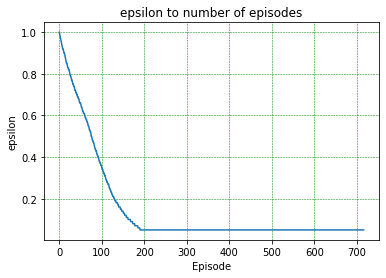

In [ ]:
plt.plot([Epsilon[i] for i in range(len(info))])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Episode')
plt.ylabel('epsilon')
plt.title('epsilon to number of episodes')
plt.show()

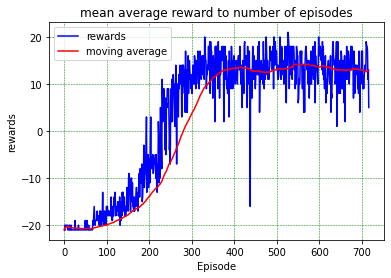

In [ ]:
plt.plot([Reward[i] for i in range(len(info))], "b", label= "rewards")
plt.plot([reward_moving_averages[i] for i in range(len(info))], "r",linewidth=1.5, label="moving average")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Episode')
plt.ylabel('rewards')
plt.title('mean average reward to number of episodes')
plt.legend()
plt.show()

In [ ]:
#maximum reward moving average
np.max(reward_moving_averages)

14.27

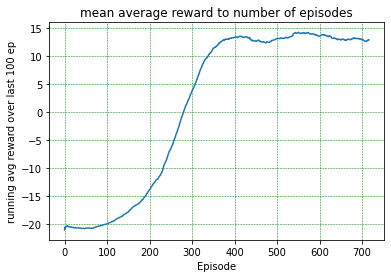

In [ ]:
plt.plot([reward_moving_averages[i] for i in range(len(info))])
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Episode')
plt.ylabel('running avg reward over last 100 ep')
plt.title('mean average reward to number of episodes')
plt.show()

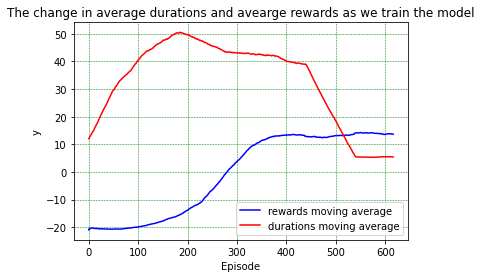

In [ ]:
plt.plot([reward_moving_averages[i] for i in range(len(info)-100)], 'b', label= "rewards moving average")
plt.plot([durations_moving_averages[i] for i in range(len(info)-100)], 'r', label= "durations moving average")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Episode')
plt.ylabel('y')
plt.title('The change in average durations and avearge rewards as we train the model')
plt.legend()
plt.show()

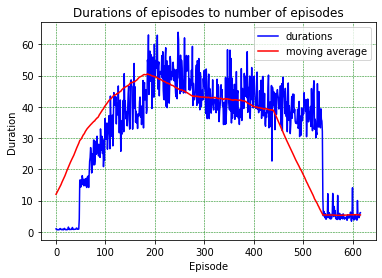

In [ ]:
plt.plot([Duration[i] for i in range(len(info)-100)], 'b', label= "durations")
plt.plot([durations_moving_averages[i] for i in range(len(info)-100)], 'r', label= "moving average")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Durations of episodes to number of episodes')
plt.legend()
plt.show()

In [ ]:
#print model surmmery
from torchsummary import summary
print("online model and target model architecture")
summary(agent.online_model, (4, 64, 80))

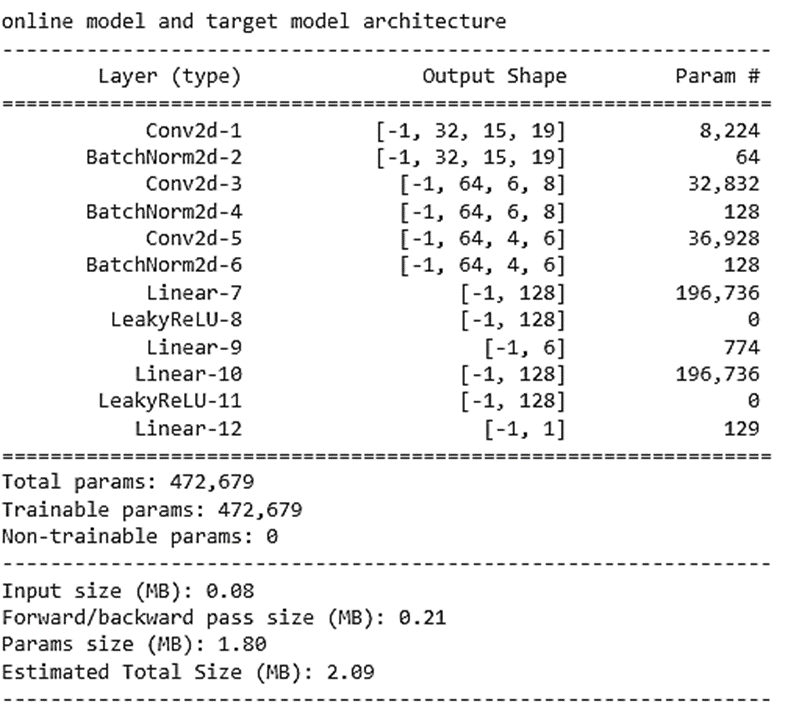